# import packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import warnings 
warnings.filterwarnings("ignore")
import time

# DATA PREPARATION
## Load the training data and test data

In [2]:
column_name = ['engine_id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
               's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
               's15', 's16', 's17', 's18', 's19', 's20', 's21']
train_FD004 = pd.read_table("./CMAPSSData/train_FD004.txt", header=None, delim_whitespace=True)
train_FD004.columns = column_name
# Test 文件中的cycle数 并不是到死的
test_FD004 = pd.read_table("./CMAPSSData/test_FD004.txt", header=None, delim_whitespace=True)
test_FD004.columns = column_name

# load RUL data 真正的最后循环数存放在这里
RUL_FD004 = pd.read_table("./CMAPSSData/RUL_FD004.txt", header=None, delim_whitespace=True)

In [3]:
train_FD004.head()

,engine_id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,42.0049,0.8400,100.0,445.00,549.68,1343.43,1112.93,3.91,...,129.78,2387.99,8074.83,9.3335,0.02,330,2212,100.00,10.62,6.3670
1,1,2,20.0020,0.7002,100.0,491.19,606.07,1477.61,1237.50,9.35,...,312.59,2387.73,8046.13,9.1913,0.02,361,2324,100.00,24.37,14.6552
2,1,3,42.0038,0.8409,100.0,445.00,548.95,1343.12,1117.05,3.91,...,129.62,2387.97,8066.62,9.4007,0.02,329,2212,100.00,10.48,6.4213
3,1,4,42.0000,0.8400,100.0,445.00,548.70,1341.24,1118.03,3.91,...,129.80,2388.02,8076.05,9.3369,0.02,328,2212,100.00,10.54,6.4176
4,1,5,25.0063,0.6207,60.0,462.54,536.10,1255.23,1033.59,7.05,...,164.11,2028.08,7865.80,10.8366,0.02,305,1915,84.93,14.03,8.6754


# Feature extention

## Difference with previous row

In [4]:
train_FD004 = train_FD004.drop(['s1','setting1','setting2','setting3','s5','s6','s10','s16','s18','s19'],axis = 1)

In [5]:
test_FD004 = test_FD004.drop(['s1','setting1','setting2','setting3','s5','s6','s10','s16','s18','s19'],axis = 1)

In [6]:
# _id =1
# s2_diff = []
# s2_diff_temp = []
# diff_periods = 40
# for _id in set(train_FD004[id]):
#     trainFD004_of_one_id =  train_FD004[train_FD004[id] == _id]
#     s2 = pd.Series(trainFD004_of_one_id['s2'])
#     for i in range(diff_periods):
#         s2_diff.append(s2.iloc[i]-s2.iloc[0])
#     s2_diff_temp=s2.diff(periods=diff_periods)
#     for j in range (len(s2)-diff_periods):
#         s2_diff.append(s2_diff_temp.iloc[diff_periods])


In [7]:
def cal_diff(df, sensor_name,diff_periods = 40):
    _id =1
    sensor_diff = []
    sensor_diff_temp = []
    for _id in set(df['engine_id']):
        trainFD004_of_one_id =  df[df['engine_id'] == _id]
        s = pd.Series(trainFD004_of_one_id[sensor_name])
        #判断每一个数列的长度是否大于diff_periods
        if len(s)>diff_periods:
            sensor_diff_temp=s.diff(periods=diff_periods)
            # 第0到39 应该是每一个值-第一个值
            for i in range(diff_periods):
                sensor_diff.append(s.iloc[i]-s.iloc[0])
            # 第40个值之后应该是每一个值-向前推40位的值
            for j in range (len(s)-diff_periods):
                sensor_diff.append(sensor_diff_temp.iloc[diff_periods+j])
        else:
            for h in range(len(s)):
                sensor_diff.append(s.iloc[h]-s.iloc[0])
    return sensor_diff

In [8]:
#from Feature_extention import cal_diff

In [9]:
#get all the names of sensors
list(train_FD004.columns)
sensor_name = list(train_FD004.columns)
sensor_name = sensor_name[2:16]
sensor_name

['s2',
 's3',
 's4',
 's7',
 's8',
 's9',
 's11',
 's12',
 's13',
 's14',
 's15',
 's17',
 's20',
 's21']

In [10]:
for i in range(len(sensor_name)):
    sensor_name_temp = sensor_name[i]
    diff = cal_diff(train_FD004,sensor_name=sensor_name_temp) 
    name = sensor_name_temp+'_diff'
    train_FD004[name] = diff

In [11]:
for i in range(len(sensor_name)):
    sensor_name_temp = sensor_name[i]
    diff = cal_diff(test_FD004,sensor_name=sensor_name_temp) 
    name = sensor_name_temp+'_diff'
    test_FD004[name] = diff

In [12]:
test_FD004

,engine_id,cycle,s2,s3,s4,s7,s8,s9,s11,s12,...,s8_diff,s9_diff,s11_diff,s12_diff,s13_diff,s14_diff,s15_diff,s17_diff,s20_diff,s21_diff
0,1,1,606.67,1481.04,1227.81,332.52,2323.67,8704.98,43.83,313.03,...,0.00,0.00,0.00,0.00,0.00,0.00,0.0000,0.0,0.00,0.0000
1,1,2,536.22,1256.17,1031.48,174.46,1915.21,7999.94,36.11,163.61,...,-408.46,-705.04,-7.72,-149.42,-359.69,-185.52,1.6403,-56.0,-9.95,-6.1259
2,1,3,549.23,1340.13,1105.88,137.34,2211.93,8305.38,41.52,129.98,...,-111.74,-399.60,-2.31,-183.05,0.17,22.15,0.1731,-34.0,-13.92,-8.2642
3,1,4,549.19,1339.70,1107.26,137.23,2211.89,8301.00,41.73,129.48,...,-111.78,-403.98,-2.10,-183.55,0.12,29.91,0.1365,-34.0,-13.75,-8.4640
4,1,5,555.10,1353.04,1117.80,192.94,2222.71,8331.05,41.32,181.82,...,-100.96,-373.93,-2.51,-131.21,0.09,8.85,0.0801,-29.0,-9.46,-5.7681
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41209,248,277,550.30,1364.40,1129.17,138.34,2212.35,8351.73,42.30,130.87,...,-111.82,-393.39,-2.11,-183.61,0.26,43.99,0.2115,-36.0,-13.61,-8.4730
41210,248,278,608.00,1494.75,1260.88,334.75,2324.23,8758.69,44.53,314.51,...,5.26,-44.94,-0.98,-56.76,0.13,-57.25,0.5827,-6.0,-4.15,-2.3911
41211,248,279,555.92,1370.65,1130.97,194.92,2223.57,8370.49,42.33,182.76,...,11.46,37.56,0.06,52.17,0.49,1.52,0.0000,5.0,4.06,2.4742
41212,248,280,608.19,1489.11,1256.25,333.15,2324.19,8753.04,44.78,314.17,...,112.04,410.87,2.72,183.74,0.14,-13.55,-0.0951,34.0,13.93,8.3970


In [13]:
train_FD004.describe()

,engine_id,cycle,s2,s3,s4,s7,s8,s9,s11,s12,...,s8_diff,s9_diff,s11_diff,s12_diff,s13_diff,s14_diff,s15_diff,s17_diff,s20_diff,s21_diff
count,61249.000000,61249.000000,61249.000000,61249.000000,61249.000000,61249.000000,61249.000000,61249.000000,61249.000000,61249.000000,...,61249.000000,61249.000000,61249.000000,61249.000000,61249.000000,61249.000000,61249.000000,61249.000000,61249.000000,61249.000000
mean,124.325181,134.311417,579.420056,1417.896600,1201.915359,283.328633,2228.686034,8524.673301,42.874529,266.735665,...,0.982480,7.775574,0.111984,1.548875,0.427146,4.262664,-0.005800,0.700011,0.094705,0.057766
std,71.995350,89.783389,37.342647,106.167598,119.327591,146.880210,145.348243,336.927547,3.243492,138.479109,...,205.218783,476.086565,4.564487,196.638733,180.971800,119.002142,1.055703,39.300465,14.120938,8.472765
min,1.000000,1.000000,535.480000,1242.670000,1024.420000,136.170000,1914.720000,7984.510000,36.040000,128.310000,...,-473.370000,-1090.630000,-11.370000,-404.480000,-360.730000,-309.860000,-2.586100,-91.000000,-29.020000,-17.338300
25%,60.000000,62.000000,549.330000,1350.550000,1119.490000,142.920000,2211.950000,8320.590000,41.760000,134.520000,...,-106.760000,-342.440000,-3.050000,-150.120000,-0.070000,-46.700000,-0.683900,-28.000000,-10.250000,-6.149300
50%,126.000000,123.000000,555.740000,1367.680000,1136.920000,194.960000,2223.070000,8362.760000,42.330000,183.450000,...,0.030000,3.410000,0.080000,0.100000,0.040000,2.740000,-0.001700,0.000000,0.010000,0.003600
75%,185.000000,191.000000,607.070000,1497.420000,1302.620000,394.280000,2323.930000,8777.250000,45.220000,371.400000,...,106.910000,369.900000,3.260000,150.480000,0.190000,54.120000,0.679900,30.000000,10.290000,6.174100
max,249.000000,543.000000,644.420000,1613.000000,1440.770000,570.810000,2388.640000,9196.810000,48.360000,537.490000,...,473.330000,1144.020000,11.620000,404.650000,360.970000,341.340000,2.591000,92.000000,29.190000,17.526500


## standard normalization 

In [14]:
#### standard normalization ####

# Training 因为前两列是没有用的 engine_id cycle
mean = train_FD004.iloc[:, 2:].mean()
std = train_FD004.iloc[:, 2:].std()
std.replace(0, 1, inplace=True)
train_FD004.iloc[:, 2:] = (train_FD004.iloc[:, 2:] - mean) / std

# Testing
test_FD004.iloc[:, 2:] = (test_FD004.iloc[:, 2:] - mean) / std

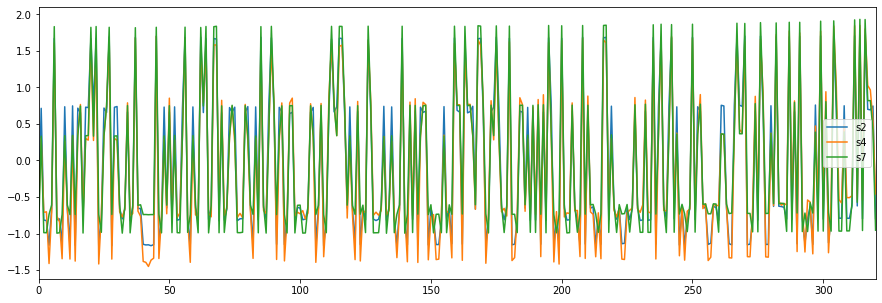

In [15]:
train_FD004[train_FD004["engine_id"]==1][["s2","s4","s7"]].plot(figsize=(15,5));

## Compute the RUL

### Training 

In [105]:
id='engine_id'
# 这个是自己定义的， 拐点在120 ，  120之前视为一样
MAXLIFE = 150
rul = [] # 会逐渐装满所有id的RUL
for _id in set(train_FD004[id]):
    trainFD004_of_one_id =  train_FD004[train_FD004[id] == _id]
    cycle_list = trainFD004_of_one_id['cycle'].tolist()
    # 因为这里是run to end ,所以最大cycle数是确定的
    max_cycle = max(cycle_list)
    # 计算出临界点的位置，没到达临界点的时候，全部保存MAXLIFE，到达临界点的时候，逐点下降！
#     if MAXLIFE >= max_cycle:
#         for i in range(0, len(cycle_list)):
#             tmp = max_cycle-i
#             kink_RUL.append(tmp)
#     else:
    knee_point = max_cycle - MAXLIFE
    kink_RUL = []
    for i in range(0, len(cycle_list)):
        # 
        if i < knee_point:
            kink_RUL.append(MAXLIFE)
        else:
            tmp = max_cycle-i-1
            kink_RUL.append(tmp)
    # 每跑完一个id就添加到最后总的rul列表中
    rul.extend(kink_RUL)
print (rul)
print(train_FD004.shape)
train_FD004["RUL"] = rul


[150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 149, 148, 147, 146, 145, 144, 143, 142, 141, 140, 139, 138, 137, 136, 135, 134, 133, 132, 131, 130, 129, 128, 127, 126, 125, 124, 123, 122, 121,

### Testing

In [106]:
id='engine_id'
rul = []
for _id_test in set(test_FD004[id]):
    # 真实的RUL， 也就是测试数据最后一个周期所对应的RUL
    true_rul = int(RUL_FD004.iloc[_id_test - 1])
    testFD004_of_one_id =  test_FD004[test_FD004[id] == _id_test]
    cycle_list = testFD004_of_one_id['cycle'].tolist()
    # 那么总的生命周期数=训练集的已有周期数+最后剩下的周期数
    max_cycle = max(cycle_list) + true_rul
    knee_point = max_cycle - MAXLIFE
    kink_RUL = []
    for i in range(0, len(cycle_list)):
        if i < knee_point:
            kink_RUL.append(MAXLIFE)
        else:
            tmp = max_cycle-i-1
            kink_RUL.append(tmp)    

    rul.extend(kink_RUL)

test_FD004["RUL"] = rul

In [107]:
min_shape = np.min([i[0] for i in train_FD004.groupby("engine_id").apply(np.shape).values])
print("训练集中最小的长度是：",min_shape)

训练集中最小的长度是： 128


In [108]:
min_shape = np.min([i[0] for i in test_FD004.groupby("engine_id").apply(np.shape).values])
print("测试集中最小的长度是：",min_shape)

测试集中最小的长度是： 19


In [109]:
train_FD004[train_FD004["engine_id"]==1].head()

,engine_id,cycle,s2,s3,s4,s7,s8,s9,s11,s12,...,s9_diff,s11_diff,s12_diff,s13_diff,s14_diff,s15_diff,s17_diff,s20_diff,s21_diff,RUL
0,1,1,-0.796410,-0.701406,-0.745723,-0.993794,-0.115764,-0.633232,-0.365202,-0.988999,...,-0.016332,-0.024534,-0.007877,-0.002360,-0.035820,0.005494,-0.017812,-0.006707,-0.006818,150
1,1,2,0.713660,0.562445,0.298210,0.332049,0.653424,0.560734,0.328495,0.331128,...,0.828640,0.468402,0.921798,-0.003797,-0.276992,-0.129203,0.770983,0.967025,0.971399,150
2,1,3,-0.815959,-0.704326,-0.711196,-0.988211,-0.115351,-0.646974,-0.374451,-0.990154,...,-0.026057,-0.031106,-0.008690,-0.002471,-0.104810,0.069148,-0.043257,-0.016621,-0.000409,150
3,1,4,-0.822653,-0.722034,-0.702984,-0.989573,-0.115626,-0.630175,-0.368285,-0.988854,...,-0.014169,-0.026724,-0.007775,-0.002195,-0.025568,0.008714,-0.068702,-0.012372,-0.000846,150
4,1,5,-1.160069,-1.532168,-1.410616,-0.738756,-2.156655,-1.572247,-1.971496,-0.741091,...,-0.680875,-1.165954,0.166707,-1.991123,-1.792343,1.429284,-0.653937,0.234779,0.265632,150


### 去掉不变的sensor的值和setting

In [110]:
train_FD004

,engine_id,cycle,s2,s3,s4,s7,s8,s9,s11,s12,...,s9_diff,s11_diff,s12_diff,s13_diff,s14_diff,s15_diff,s17_diff,s20_diff,s21_diff,RUL
0,1,1,-0.796410,-0.701406,-0.745723,-0.993794,-0.115764,-0.633232,-0.365202,-0.988999,...,-0.016332,-0.024534,-0.007877,-0.002360,-0.035820,0.005494,-0.017812,-0.006707,-0.006818,150
1,1,2,0.713660,0.562445,0.298210,0.332049,0.653424,0.560734,0.328495,0.331128,...,0.828640,0.468402,0.921798,-0.003797,-0.276992,-0.129203,0.770983,0.967025,0.971399,150
2,1,3,-0.815959,-0.704326,-0.711196,-0.988211,-0.115351,-0.646974,-0.374451,-0.990154,...,-0.026057,-0.031106,-0.008690,-0.002471,-0.104810,0.069148,-0.043257,-0.016621,-0.000409,150
3,1,4,-0.822653,-0.722034,-0.702984,-0.989573,-0.115626,-0.630175,-0.368285,-0.988854,...,-0.014169,-0.026724,-0.007775,-0.002195,-0.025568,0.008714,-0.068702,-0.012372,-0.000846,150
4,1,5,-1.160069,-1.532168,-1.410616,-0.738756,-2.156655,-1.572247,-1.971496,-0.741091,...,-0.680875,-1.165954,0.166707,-1.991123,-1.792343,1.429284,-0.653937,0.234779,0.265632,150
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61244,249,251,0.693843,0.927434,0.950029,0.825580,0.625903,0.936364,0.988278,0.819072,...,1.043370,0.849606,1.257896,0.000292,0.684671,-0.742539,1.076323,1.306945,1.314711,4
61245,249,252,1.713857,1.705072,1.884347,1.935328,1.099318,1.758380,1.592565,1.937363,...,0.778019,0.779500,1.102179,-0.001310,0.872651,-0.854407,0.745538,1.029343,1.052506,3
61246,249,253,1.720819,1.787960,1.916109,1.945200,1.099593,1.786309,1.654227,1.940180,...,0.805451,0.801408,1.100552,-0.001145,0.964666,-0.783933,0.745538,1.064044,1.071791,2
61247,249,254,-0.633326,-0.344800,-0.450318,-0.567800,-0.033754,-0.359226,-0.106222,-0.569152,...,0.056113,0.071863,0.009109,0.000734,0.288712,-0.171261,0.033078,0.024453,-0.015457,1


### plot a figure

training (61249, 28) (61249,)
testing (41214, 28) (41214,)


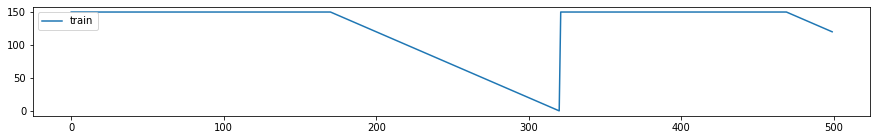

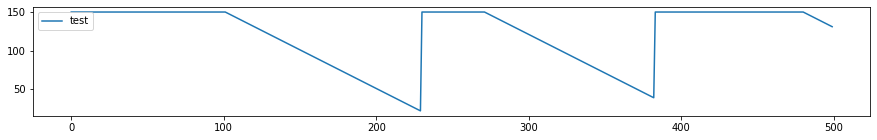

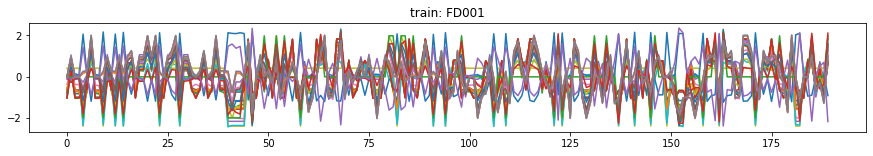

In [111]:
training_data = train_FD004.values
testing_data = test_FD004.values

x_train = training_data[:, 2:-1]
y_train = training_data[:, -1]
print("training", x_train.shape, y_train.shape)

x_test = testing_data[:, 2:-1]
y_test = testing_data[:, -1]
print("testing", x_test.shape, y_test.shape)
# 训练数据集 前面500个数据点所对应的rul 由图中可以看出  都是到零的了
plt.figure(figsize=(15,2))
plt.plot(y_train[:500], label="train")
plt.legend()
plt.figure(figsize=(15,2))
# 测试数据中前500个数据点对应的tul  可以看到结尾数据的rul 都不是中间
plt.plot(y_test[:500], label="test")
plt.legend()
plt.figure(figsize=(15,2))
plt.plot(x_train[:190])
plt.title("train: FD00" + str(1))
# 训练数据第一个id的 24个senor的值 可以通过在x轴坐标100的位置 序列的一些 趋势

plt.show()

In [112]:
def batch_generator(training_data, sequence_length=15, window_size = 15):
    """
    Generator function for creating random batches of training-data for many to many models
    """
    engine_ids = list(training_data["engine_id"].unique())
    temp = training_data.copy()
    # 把 每一段后一截给截掉，获取能够跑的index
    for id_ in engine_ids:
        indexes = temp[temp["engine_id"] == id_].index
        traj_data = temp.loc[indexes]
        # cutoff_cycle 记录下这以后的index就不满足 序列大小的需求的
        cutoff_cycle = max(traj_data['cycle']) - sequence_length - window_size + 1
        
        if cutoff_cycle<0:
            # 也就是步长和窗口大小已经大于了该机器的已有周期数，全部都得扔掉
            drop_range = indexes
            print("有一些数据直接就被抛弃了，请合理设置窗口大小和时间长度")
        else:
            cutoff_cycle_index = traj_data['cycle'][traj_data['cycle'] == cutoff_cycle+2].index
            drop_range = list(range(cutoff_cycle_index[0], indexes[-1] + 1))
            
        temp.drop(drop_range, inplace=True)
    indexes = temp.index
    del temp
    

    x_shape = (len(indexes), sequence_length, window_size, 28)
    x_batch = np.zeros(shape=x_shape, dtype=np.float32)
    y_shape = (len(indexes), sequence_length)
    y_batch = np.zeros(shape=y_shape, dtype=np.float32)
    
    # 第一个数据集
    alt_index = indexes[0]
    for batch_index, index in enumerate(indexes):
        # 因为对齐的原因，都减去了1
        y_batch[batch_index] = training_data.iloc[index+window_size-1:index+window_size-1+sequence_length,-1].values
        
        # 本来应该下面这个 for 循环的，但是考虑到循环的嵌套，跑太久了，而且窗口序列之间又有重复，那么减少循环的次数
        # for seq in range(sequence_length):
            # x_batch[index,seq] = training_data.iloc[idx+seq:idx+seq + window_size, 2:-1].values
        
        if index-alt_index==1 and batch_index!=0:
            temp_window = training_data.iloc[index+sequence_length-1:index+sequence_length-1 + window_size, 2:-1].values.reshape(1,window_size,-1)
            x_batch[batch_index] = np.concatenate((x_batch[batch_index-1][1:],temp_window))
        else:
            for seq in range(sequence_length):
                x_batch[batch_index][seq] = training_data.iloc[index+seq:index+seq + window_size, 2:-1].values
        alt_index = index
    # 如果数据集过于大的情况下 应该使用yield来构成 循环的 generator、
    
    return x_batch, y_batch

In [113]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import TimeDistributed
#from tensorflow.keras.layers.convolutional import Conv3D
#from tensorflow.keras.layers.convolutional_recurrent import ConvLSTM2D
import tensorflow.keras as keras
import tensorflow.keras.layers as layers

In [114]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np

from tensorflow.python.keras import activations
from tensorflow.python.keras import backend as K
from tensorflow.python.keras import constraints
from tensorflow.python.keras import initializers
from tensorflow.python.keras import regularizers
from tensorflow.python.keras.engine.base_layer import Layer
from tensorflow.python.keras.layers.recurrent import DropoutRNNCellMixin
from tensorflow.python.keras.utils import conv_utils
from tensorflow.python.ops import array_ops
from tensorflow.python.util.tf_export import keras_export
from tensorflow.compat.v2.keras.layers import ConvLSTM2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import TimeDistributed
#from tensorflow.keras.layers.convolutional import Conv3D
#from tensorflow.keras.layers.convolutional_recurrent import ConvLSTM2D
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
from tensorflow.python.keras.layers.recurrent import RNN
from tensorflow.python.keras.utils import tf_utils
from tensorflow.python.keras.engine.input_spec import InputSpec
from tensorflow.python.keras.layers.recurrent import _standardize_args
from tensorflow.python.keras.utils import generic_utils


In [115]:
sequence_length=5
window_size = 15
kernel_size = 3

In [116]:
x_batch, y_batch =batch_generator(train_FD004,sequence_length=sequence_length,window_size = window_size)
# 这里需要把输入数据增加一个channel层数
x_batch = np.expand_dims(x_batch, axis=4)
y_batch = np.expand_dims(y_batch, axis=2)

In [118]:
from ConvLSTM2D_2 import ConvLSTM2D_2

In [122]:
model =Sequential()
# input 的shape 应该是 （时间，行-window，列-sensor， channels）
# 参数个数怎么算？？？为啥改变filter个数，参数个数不是按比例增长
# 增加batch ？ 增加 dropout??
model.add(ConvLSTM2D_2(filters=10, kernel_size=(kernel_size, 28),input_shape=(None, window_size, 28, 1), padding='valid', return_sequences=True))
model.add(keras.layers.BatchNormalization())
model.add(ConvLSTM2D_2(filters=20, kernel_size=(kernel_size, 1),padding='valid', return_sequences=True))
model.add(keras.layers.BatchNormalization())
model.add(TimeDistributed(Flatten()))
model.add(tf.compat.v2.keras.layers.Dropout(0.5))
model.add(TimeDistributed(Dense(units = 100, activation = "linear")))
model.add(TimeDistributed(Dense(units = 1, activation = "linear")))
model.compile(loss='mse', optimizer='Adam')

In [123]:
print(model.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d_2_8 (ConvLSTM2D (None, None, 11, 1, 10)   39700     
_________________________________________________________________
batch_normalization_8 (Batch (None, None, 11, 1, 10)   40        
_________________________________________________________________
conv_lst_m2d_2_9 (ConvLSTM2D (None, None, 7, 1, 20)    18080     
_________________________________________________________________
batch_normalization_9 (Batch (None, None, 7, 1, 20)    80        
_________________________________________________________________
time_distributed_12 (TimeDis (None, None, 140)         0         
_________________________________________________________________
dropout_2 (Dropout)          (None, None, 140)         0         
_________________________________________________________________
time_distributed_13 (TimeDis (None, None, 100)        

In [125]:
model.fit(x_batch,y_batch, batch_size=15, epochs=30, validation_split=0.05)

Train on 53928 samples, validate on 2839 samples
Epoch 1/30
53928/53928 [==============================] - 160s 3ms/sample - loss: 428.2576 - val_loss: 684.7735
Epoch 2/30
53928/53928 [==============================] - 158s 3ms/sample - loss: 410.2608 - val_loss: 719.9026
Epoch 3/30
53928/53928 [==============================] - 159s 3ms/sample - loss: 398.5210 - val_loss: 702.9507
Epoch 4/30
53928/53928 [==============================] - 159s 3ms/sample - loss: 384.6650 - val_loss: 864.1981
Epoch 5/30
53928/53928 [==============================] - 157s 3ms/sample - loss: 370.4329 - val_loss: 751.8451
Epoch 6/30
53928/53928 [==============================] - 158s 3ms/sample - loss: 363.9241 - val_loss: 646.4896
Epoch 7/30
53928/53928 [==============================] - 158s 3ms/sample - loss: 359.2407 - val_loss: 677.3326
Epoch 8/30
53928/53928 [==============================] - 159s 3ms/sample - loss: 347.4833 - val_loss: 737.5259
Epoch 9/30
53928/53928 [==============================]

KeyboardInterrupt: 

# Evaluation

## Tranining Performance

In [126]:
y_batch_pred = model.predict(x_batch)

In [127]:
from sklearn.metrics import mean_squared_error
y_batch_pred = y_batch_pred.reshape(y_batch_pred.shape[0], y_batch_pred.shape[1])
y_batch_reshape = y_batch.reshape(y_batch.shape[0], y_batch.shape[1])
np.sqrt(mean_squared_error(y_batch_pred, y_batch_reshape))

16.266865

## Test Performance

## Evaluation Method 1

In [128]:
def test_batch_generator(test_data, sequence_length=10, window_size = 10):
    """
    这里的seq 和 win size 必须要和前面training的一致
    """
    engine_ids = list(test_data["engine_id"].unique())
    index_list=[]
    temp = test_data.copy()
    for id_ in engine_ids:
        indexes = temp[temp["engine_id"] == id_].index
        traj_data = temp.loc[indexes]
        # 找到对应的index，index以前的数据相当于抛弃了，，这个有待改进
        cutoff_cycle = max(traj_data['cycle']) - sequence_length - window_size + 2
        
        if cutoff_cycle<0:
            # 也就是步长和窗口大小已经大于了该机器的已有周期数，全部都得扔掉
            print("有一些数据直接就被抛弃了，请合理设置窗口大小和时间长度")
        else:
            cutoff_cycle_index = traj_data['cycle'][traj_data['cycle'] == cutoff_cycle].index
            index_list.append(cutoff_cycle_index.values[0])
            

    del temp
    

    x_shape = (len(index_list), sequence_length, window_size, 28)
    x_batch = np.zeros(shape=x_shape, dtype=np.float32)
    y_shape = (len(index_list), sequence_length)
    y_batch = np.zeros(shape=y_shape, dtype=np.float32)
    


    for test_index, index in enumerate(index_list):
        y_batch[test_index] = test_data.iloc[index+window_size-1:index+window_size-1+sequence_length,-1].values
        
        for seq in range(sequence_length):
            x_batch[test_index][seq] = test_data.iloc[index+seq:index+seq + window_size, 2:-1].values
    # 如果数据集过于大的情况下 应该使用yield来构成 循环的 generator、
    
    return x_batch, y_batch

In [129]:
x_batch_test, y_batch_test =  test_batch_generator(test_FD004, sequence_length=sequence_length,window_size = window_size)
x_batch_test = np.expand_dims(x_batch_test, axis=4)

In [130]:
y_batch_pred_test = model.predict(x_batch_test)

In [131]:
y_batch_pred_test = y_batch_pred_test.reshape(y_batch_pred_test.shape[0],y_batch_pred_test.shape[1])
y_batch_pred_last_values_test = [i[-1] for i in y_batch_pred_test]
y_batch_last_values_test = [i[-1] for i in y_batch_test]

In [132]:
np.sqrt(mean_squared_error(y_batch_pred_last_values_test, y_batch_last_values_test))

24.632967